In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.inspection import PartialDependenceDisplay
from xgboost import XGBClassifier


import shap
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from joblib import dump, load

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = "{:,.4}".format


# Run H2O later
import h2o
import pandoc
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2ORandomForestEstimator, H2ODecisionTreeEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2OKMeansEstimator
from h2o.automl import H2OAutoML
h2o.init(max_mem_size = "20G") # need more memory
#h2o.init() # need more memory

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.23" 2024-04-16 LTS; OpenJDK Runtime Environment Zulu11.72+19-CA (build 11.0.23+9-LTS); OpenJDK 64-Bit Server VM Zulu11.72+19-CA (build 11.0.23+9-LTS, mixed mode)
  Starting server from /opt/anaconda3/lib/python3.12/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/z5/xxddnyr978bb97d94x1wj3780000gn/T/tmp96srg0t1
  JVM stdout: /var/folders/z5/xxddnyr978bb97d94x1wj3780000gn/T/tmp96srg0t1/h2o_luis_started_from_python.out
  JVM stderr: /var/folders/z5/xxddnyr978bb97d94x1wj3780000gn/T/tmp96srg0t1/h2o_luis_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,16 days
H2O_cluster_name:,H2O_from_python_luis_oovuc7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,20 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


In [3]:
def firingRate(df):
    return 1-df.isna().sum(axis=0)/df.shape[0]

def uniqueCount(df):
    return df.nunique()

def uniqueRate(df):
    return df.nunique()/df.shape[0]

def firingRateDetailed(df):
    output = []
    firingRate = 1-df.isna().sum(axis=0)/df.shape[0]
    uniqueCount = df.nunique()
    uniqueRate = df.nunique()/df.shape[0]
    for i in df.columns:
        if df[i].dtypes == 'O':
            if df[i].nunique() <= 15:
                output.append(df[i].value_counts(dropna = False, normalize = True))
            else:
                output.append((i+': Categorical Column with '+ str(df[i].nunique()) + ' groups'))
        elif (df[i].dtypes in ['int8','int16','int32','int64','float32','float64']):
            output.append(df[i].describe())
        else:
            df[i] = df[i].astype(str)
            if df[i].nunique() <= 15:
                output.append(df[i].value_counts(dropna = False, normalize = True))
            else:
                output.append((i+': Categorical Column with '+ str(df[i].nunique()) + ' groups'))
    final = pd.DataFrame({'Column': df.columns,
                          'firingRate': firingRate,
                          'uniqueCount': uniqueCount,
                          'uniqueRate': uniqueRate,
                          'Detailed_Summary': output})   
    return(final)

def compute_class_weights(y):
    # Calculate the class weights
    class_weights = compute_class_weight(
        class_weight="balanced", classes=np.unique(y), y=y
    )

    # Convert the result to a dictionary with class labels as keys
    class_weight_dict = dict(zip(np.unique(y), class_weights))

    # Create an array of the same length as y with the corresponding class weight for each element
    class_weights_array = np.array([class_weight_dict[label] for label in y])

    return class_weights_array

## Read in files

In [5]:
df = pd.read_parquet("giggle_user_ids_33603_w2flags_20241116.parquet")

## Create Samples
### Class 0 - Non W2
### Class 1 - W2

In [7]:
cl0 = df[df['W2_INCOME']==0]
print(cl0.shape)
cl1 = df[df['W2_INCOME']==1]
print(cl1.shape)

(33261, 5021)
(342, 5021)


In [9]:
train0 = cl0.sample(int(len(cl0)*.7), random_state = 181, replace = False)
test0 = cl0[~cl0.USER_ID.isin(train0.USER_ID.tolist())]

train1 = cl1.sample(int(len(cl1)*.7), random_state = 181, replace = False)
test1 = cl1[~cl1.USER_ID.isin(train1.USER_ID.tolist())]

train = pd.concat([train0, train1])
test = pd.concat([test0, test1])

train = train.sample(int(len(train)), random_state = 191, replace = False)
test = test.sample(int(len(test)), random_state = 191, replace = False)

print("Train Size: " + str(len(train)))
print("Train W2's: " + str(len(train[train['W2_INCOME'] == 1])))
print("Test Size: " + str(len(test)))
print("Test W2's: " + str(len(test[test['W2_INCOME'] == 1])))

train['dataset'] = 'train'
test['dataset'] = 'test'

combine = pd.concat([train, test])
combine = combine.sample(int(len(combine)), random_state = 191, replace = False).reset_index(drop = True)
print("Combined Data Size: " + str(len(combine)))




Train Size: 23521
Train W2's: 239
Test Size: 10082
Test W2's: 103
Combined Data Size: 33603


## List of predictors/non-predictors

### Read in Feature Selection Results (display top 10)

In [11]:
top_features = pd.read_csv("Feature_Selection_84_20241118.csv")
top_features.head(10)

,Variable,Total Relative Importance
0,EARNED_WAGE_ACCESS_COUNT_TREND_MONTH_3,6.003e+04
1,EARNED_WAGE_ACCESS_COUNT_PAST_180D,5.892e+04
2,EARNED_WAGE_ACCESS_COUNT_PAST_270D,4.417e+04
3,EARNED_WAGE_ACCESS_COUNT_TREND_MONTH_1,4.019e+04
4,GIG_INCOME_TO_INCOME_RATIO_PAST_180D,3.797e+04
5,EARNED_WAGE_ACCESS_TREND_MONTH_1,3.637e+04
6,INCOME_NEXT_7D,3.605e+04
7,EARNED_WAGE_ACCESS_TREND_MONTH_3,3.582e+04
8,INCOME_NEXT_30D,3.446e+04
9,RENT_TO_INCOME_RATIO_PAST_360D,3.119e+04


In [13]:
predictors = top_features.Variable.tolist()
outcome_flag = 'W2_INCOME'

## These will be columns to keep in H2O Frame (show last 5)

In [15]:
col_keep = predictors+['W2_INCOME', 'dataset']
col_keep[80:85]

['MEDIAN_BNPL_PAYMENT_PAST_30D',
 'DEBT_PMT_STD_PAST_2Y',
 'MEDIAN_BNPL_LOAN_AMOUNT_PAST_90D',
 'OBLIGATORY_OUTFLOWS_TO_OUTFLOWS_RATIO_PAST_90D',
 'W2_INCOME']

## Convert DataFrame to H2O Frame

In [17]:
df_h2o = h2o.H2OFrame(combine[col_keep])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [19]:
import time
start = time.time()
# Fix Column Types in h2o
# If column enum has "9 or more" values, turn numeric (to prevent high cardinality in categorical)
for i in df_h2o.columns:
    if (df_h2o.types[i] == "enum"):
        if len(df_h2o[i].levels()[0]) >= 9:
            df_h2o[i] = df_h2o[i].asnumeric()
            
    #elif df_h2o.types[i] == "int":
    #    df_h2o[i] = df_h2o[i].asnumeric()
end = time.time()
print("Execution time:", end - start, "seconds")
#df_h2o.types

Execution time: 3.9899189472198486 seconds


In [20]:
df_h2o["W2_INCOME"] = df_h2o["W2_INCOME"].asfactor()

In [21]:
df_train = df_h2o[df_h2o['dataset'] == 'train']
df_test = df_h2o[df_h2o['dataset'] == 'test']

## Grid Search of Models (Using Random Forest Estimator)

In [25]:
drf_params1 = {
    "max_depth": [5, 7, 10, 15, 20, 25],               # Extended range
    "sample_rate": [0.5, 0.6, 0.7, 0.8, 0.9],         # More options for sampling
    "ntrees": [10, 15, 20, 25, 30, 35, 40, 50],       # Larger range for tree count
    "min_rows": [1, 5, 10, 20, 50],                   # Smaller minimum rows for high granularity
    "mtries": [1, 3, 5, -1],                          # Add '-1' for auto (sqrt of predictors)
    "nbins": [10, 20, 30, 40, 50],                    # Number of bins for histogram splitting
    "nbins_top_level": [50, 100, 200],                # Top-level histogram bins
    "nbins_cats": [16, 64, 256],                      # For categorical predictors
    "col_sample_rate_per_tree": [0.5, 0.6, 0.7, 0.8], # Column sampling for each tree
    "distribution": ["bernoulli"],     # Add support for other distributions if applicable
    "seed": [1234]                              # Add seeds for reproducibility
}


search_criteria = {
    'strategy': "RandomDiscrete",
    'max_models': 100,             # Limit runtime to 20 minutes
    'max_runtime_secs': 1200,
    'stopping_metric': "AUC",             # Stop based on AUC
    'stopping_rounds': 5,
    'stopping_tolerance': 0.001,
    'seed': 1234 
}

# Initialize the Random Forest estimator with balance_classes enabled
rf_model = H2ORandomForestEstimator(
    seed=1,
    nfolds = 5,
    balance_classes=True   # Enables class balancing for imbalanced data
)

# Create and run the grid search
rf_grid = H2OGridSearch(
    model=rf_model,
    hyper_params=drf_params1,
    grid_id='drf_grid1',
    search_criteria=search_criteria
)


rf_grid.train(x=predictors, 
                y=outcome_flag,
                training_frame= df_train,
              validation_frame= df_test,
                seed=1)

drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,col_sample_rate_per_tree,distribution,max_depth,min_rows,mtries,nbins,nbins_cats,nbins_top_level,ntrees,sample_rate,seed,model_ids,logloss
,0.8,bernoulli,5.0,10.0,-1.0,10.0,256.0,200.0,35.0,0.6,1234.0,drf_grid1_model_43,0.0452794
,0.6,bernoulli,7.0,50.0,-1.0,10.0,16.0,100.0,15.0,0.5,1234.0,drf_grid1_model_86,0.0454753
,0.6,bernoulli,5.0,1.0,-1.0,30.0,256.0,200.0,10.0,0.7,1234.0,drf_grid1_model_28,0.0455021
,0.6,bernoulli,5.0,20.0,-1.0,30.0,256.0,100.0,35.0,0.8,1234.0,drf_grid1_model_72,0.0455302
,0.5,bernoulli,5.0,20.0,-1.0,20.0,64.0,50.0,40.0,0.8,1234.0,drf_grid1_model_49,0.0455320
,0.7,bernoulli,5.0,10.0,-1.0,50.0,64.0,50.0,50.0,0.6,1234.0,drf_grid1_model_94,0.0455838
,0.7,bernoulli,5.0,10.0,-1.0,40.0,256.0,100.0,25.0,0.8,1234.0,drf_grid1_model_84,0.0459985
,0.5,bernoulli,5.0,50.0,5.0,40.0,64.0,50.0,50.0,0.6,1234.0,drf_grid1_model_26,0.0461046
,0.6,bernoulli,5.0,5.0,5.0,10.0,16.0,200.0,30.0,0.5,1234.0,drf_grid1_model_35,0.0462889
,0.7,bernoulli,5.0,50.0,5.0,20.0,64.0,50.0,30.0,0.7,1234.0,drf_grid1_model_12,0.0463223


## Leaderboard results

In [28]:
leaderboard = rf_grid.get_grid(sort_by='auc', decreasing=True)
leaderboard

,col_sample_rate_per_tree,distribution,max_depth,min_rows,mtries,nbins,nbins_cats,nbins_top_level,ntrees,sample_rate,seed,model_ids,auc
,0.5,bernoulli,20.0,50.0,-1.0,10.0,256.0,100.0,30.0,0.8,1234.0,drf_grid1_model_78,0.9059074
,0.5,bernoulli,15.0,50.0,5.0,10.0,16.0,200.0,50.0,0.6,1234.0,drf_grid1_model_85,0.9052891
,0.7,bernoulli,10.0,20.0,5.0,40.0,16.0,200.0,40.0,0.5,1234.0,drf_grid1_model_25,0.9047158
,0.5,bernoulli,15.0,50.0,-1.0,10.0,256.0,200.0,30.0,0.9,1234.0,drf_grid1_model_79,0.9042310
,0.5,bernoulli,10.0,50.0,3.0,40.0,256.0,100.0,40.0,0.8,1234.0,drf_grid1_model_52,0.9017198
,0.5,bernoulli,10.0,50.0,-1.0,10.0,64.0,50.0,10.0,0.7,1234.0,drf_grid1_model_81,0.8988795
,0.6,bernoulli,25.0,50.0,3.0,30.0,256.0,50.0,35.0,0.7,1234.0,drf_grid1_model_64,0.8935552
,0.5,bernoulli,7.0,20.0,-1.0,30.0,64.0,50.0,35.0,0.8,1234.0,drf_grid1_model_73,0.8934037
,0.6,bernoulli,7.0,50.0,-1.0,10.0,16.0,100.0,15.0,0.5,1234.0,drf_grid1_model_86,0.8934011
,0.6,bernoulli,10.0,50.0,-1.0,20.0,256.0,100.0,10.0,0.8,1234.0,drf_grid1_model_21,0.8915046


## Compute Training, Cross Validation, and Validation AUC's

In [30]:
results = []

# Iterate through each model in the leaderboard
for model in leaderboard.models:
    model_id = model.model_id                       # Get the model ID
       
    # Retrieve the model from the H2O cluster
    model_obj = h2o.get_model(model_id)

    #validation_auc = model.auc(valid=True)          # Get the validation AUC
    validation_auc = model_obj.model_performance(df_test).auc()
    
    # Train AUC
    #train_auc = model_obj.auc(train=True)
    train_auc = model_obj.model_performance(df_train).auc()
    
    # Check for cross-validation metrics summary
    if model_obj.cross_validation_metrics_summary():
        # Extract AUC from the cross-validation summary
        cv_auc = model_obj.cross_validation_metrics_summary().as_data_frame().loc[2, 'mean']  # Extract mean AUC
    else:
        cv_auc = None  # If no cross-validation is available
    
    # Append the results to the list
    results.append({
        'model_id': model_id,
        'train_auc': train_auc,
        'validation_auc': validation_auc,
        'cross_validation_auc': cv_auc
    })

# Convert the results list into a Pandas DataFrame
df = pd.DataFrame(results)

## Display the model results (AUC Performance)

In [35]:
df['overtraining_metric'] = np.array(df['train_auc']) - np.array(df['validation_auc']) ## the smaller the better
df.sort_values("overtraining_metric", ascending = True)

,model_id,train_auc,validation_auc,cross_validation_auc,overtraining_metric
31,drf_grid1_model_28,0.9405,0.9409,0.8784,-0.0003594
51,drf_grid1_model_23,0.9262,0.9258,0.8656,0.0003516
17,drf_grid1_model_94,0.9453,0.9419,0.8859,0.003448
14,drf_grid1_model_72,0.9456,0.9422,0.8882,0.003467
12,drf_grid1_model_49,0.9461,0.9417,0.8882,0.004408
39,drf_grid1_model_35,0.9357,0.9309,0.8735,0.004847
24,drf_grid1_model_84,0.9447,0.9394,0.8834,0.00534
47,drf_grid1_model_42,0.9245,0.9187,0.8683,0.005756
71,drf_grid1_model_15,0.905,0.8979,0.8516,0.007063
22,drf_grid1_model_12,0.9312,0.9234,0.882,0.007748


## Save Grid

In [37]:
h2o.save_grid("giggle_w2flag_models_grid", rf_grid.grid_id)

'giggle_w2flag_models_grid/drf_grid1'

In [ ]:
## Best Model 'drf_grid1_model_15'

## Get H2O Model

In [40]:
model = h2o.get_model('drf_grid1_model_12')

## Variable Importance

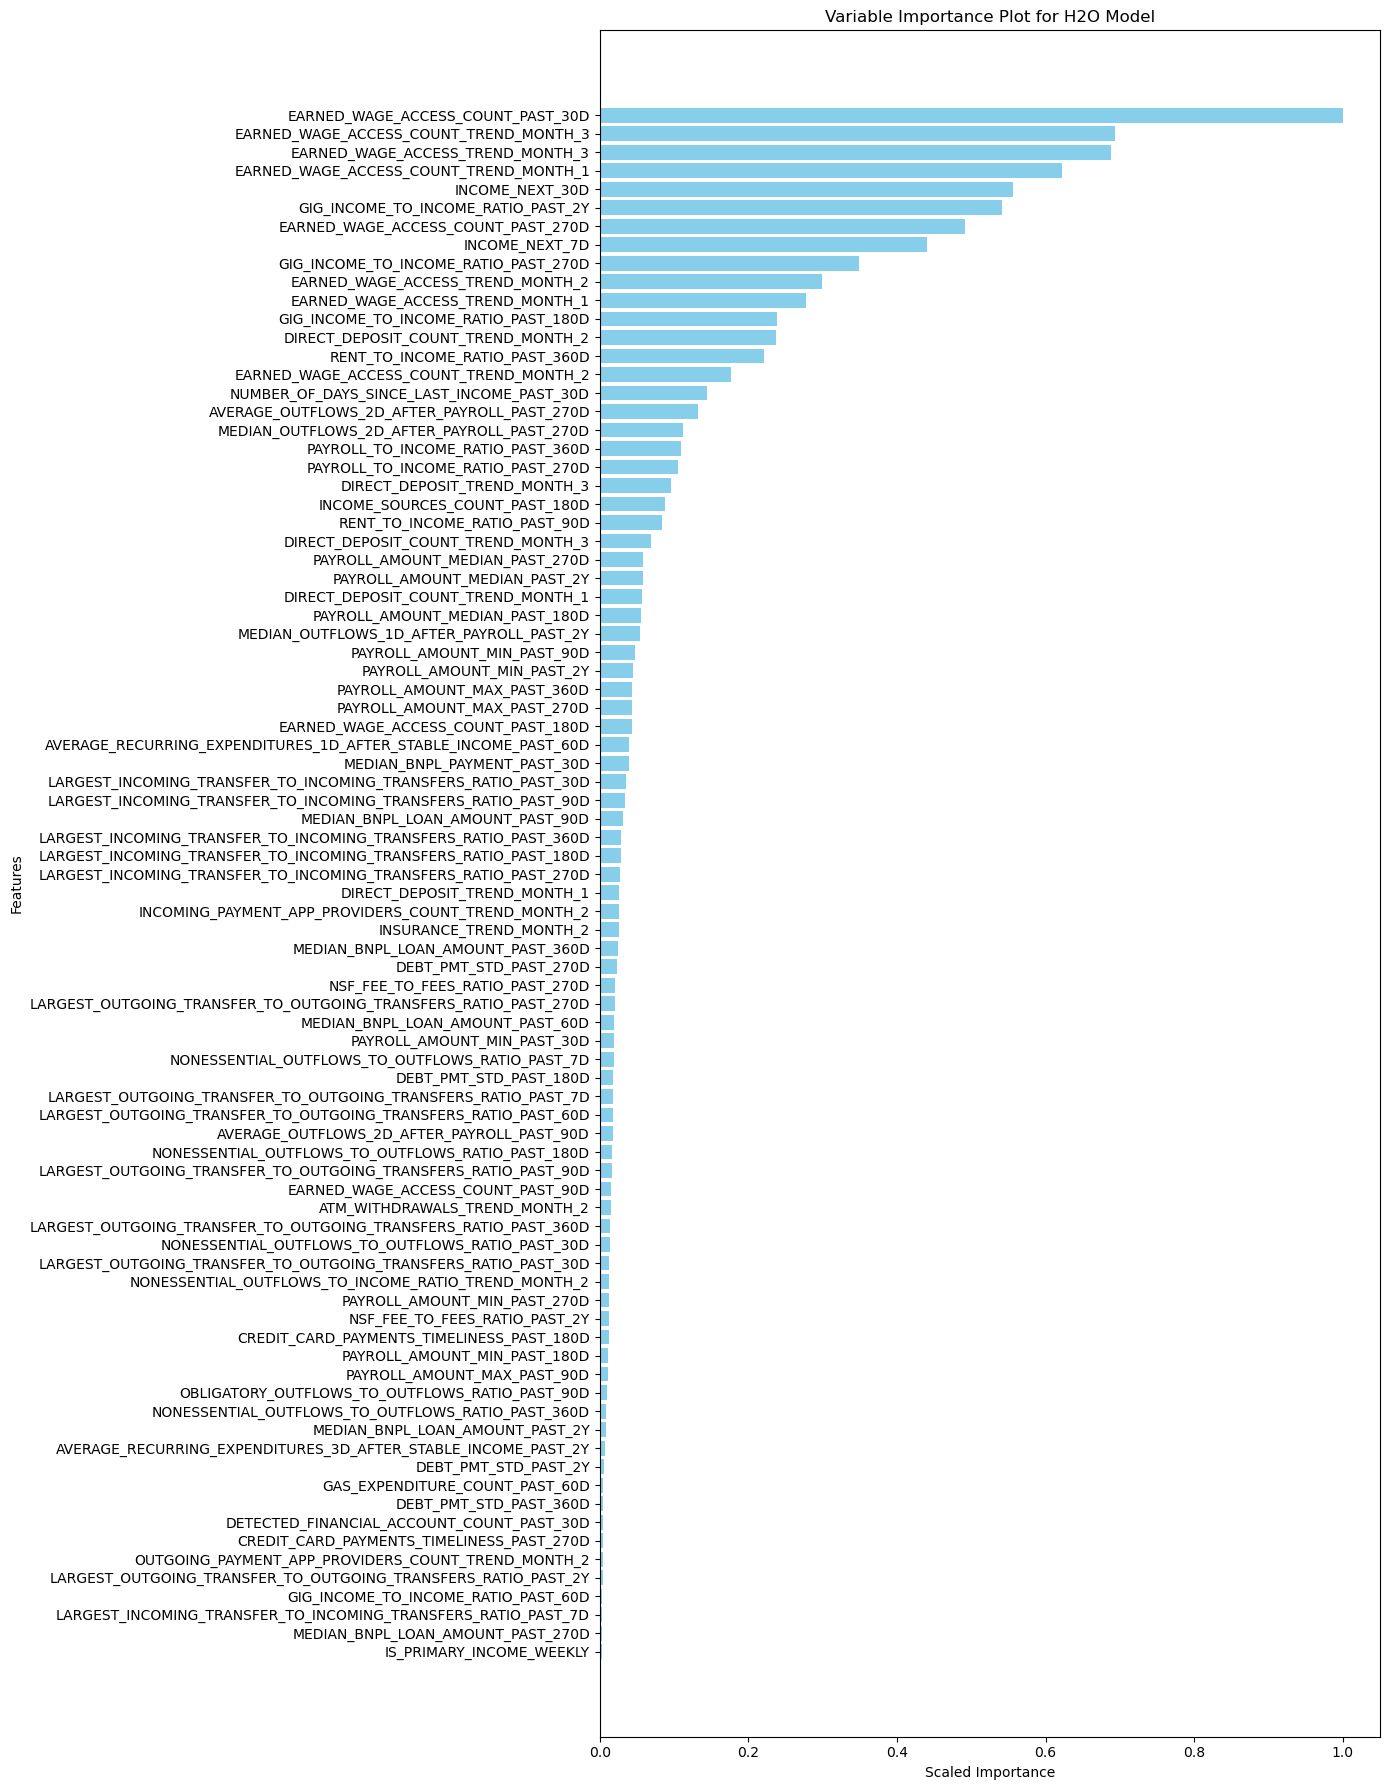

In [57]:
#Get variable importance as a Pandas DataFrame
var_importance = model.varimp(use_pandas=True)

# Sort by scaled importance for better visualization
var_importance = var_importance.sort_values('scaled_importance', ascending=True)

# Plot variable importance
plt.figure(figsize=(14, 18))
plt.barh(var_importance['variable'], var_importance['scaled_importance'], color='skyblue')
plt.xlabel('Scaled Importance')
plt.ylabel('Features')
plt.title('Variable Importance Plot for H2O Model')
plt.tight_layout()
plt.show()

## Test AUC Performance

In [66]:
scores = model.predict(df_test)
test = df_test.as_data_frame()
test['w2_score'] = scores.as_data_frame()['p1']

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


## Plot ROC Curve

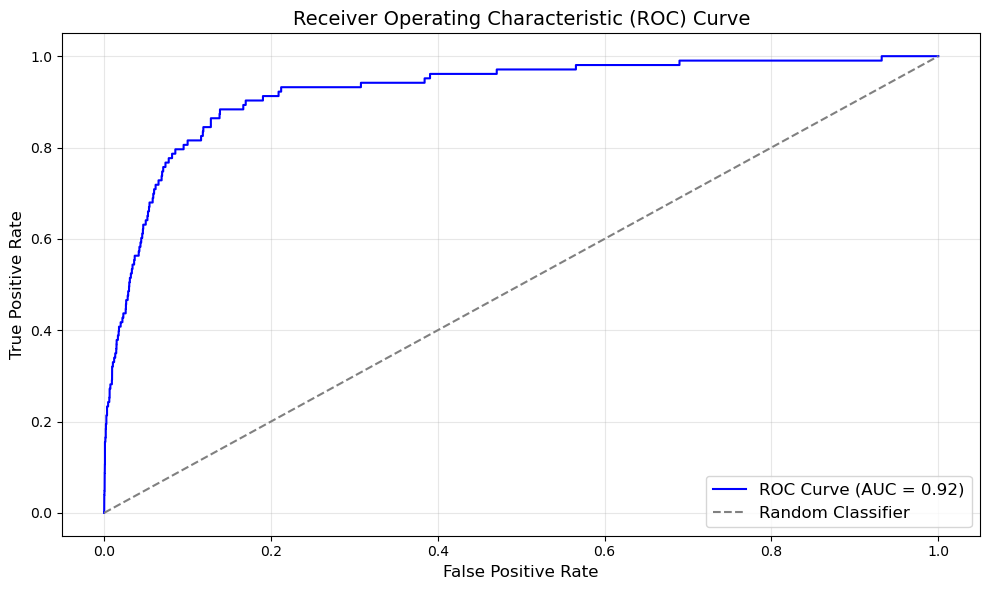

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Example: Ensure you have your test DataFrame
# test = ... # Your DataFrame with columns "w2_score" and "w2_outcome"

# Extract actual outcomes and predicted scores
y_true = test["W2_INCOME"]
y_scores = test["w2_score"]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_score = roc_auc_score(y_true, y_scores)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random Classifier')

# Add labels, title, and legend
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)

# Beautify the plot
plt.tight_layout()
plt.show()



## More Detailed view of Top Variables

In [78]:
var_importance.sort_values("relative_importance", ascending = False)

,variable,relative_importance,scaled_importance,percentage
0,EARNED_WAGE_ACCESS_COUNT_PAST_30D,1.271e+04,1.0,0.1101
1,EARNED_WAGE_ACCESS_COUNT_TREND_MONTH_3,8.813e+03,0.6934,0.07633
2,EARNED_WAGE_ACCESS_TREND_MONTH_3,8.748e+03,0.6883,0.07577
3,EARNED_WAGE_ACCESS_COUNT_TREND_MONTH_1,7.904e+03,0.6219,0.06846
4,INCOME_NEXT_30D,7.07e+03,0.5563,0.06124
5,GIG_INCOME_TO_INCOME_RATIO_PAST_2Y,6.874e+03,0.5408,0.05953
6,EARNED_WAGE_ACCESS_COUNT_PAST_270D,6.247e+03,0.4915,0.05411
7,INCOME_NEXT_7D,5.602e+03,0.4408,0.04852
8,GIG_INCOME_TO_INCOME_RATIO_PAST_270D,4.431e+03,0.3486,0.03838
9,EARNED_WAGE_ACCESS_TREND_MONTH_2,3.8e+03,0.299,0.03292


## H2O Explainability Plots

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## drf_grid1_model_12

,0,1,Error,Rate
0,9944.0,35.0,0.0035,(35.0/9979.0)
1,79.0,24.0,0.767,(79.0/103.0)
Total,10023.0,59.0,0.0113,(114.0/10082.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

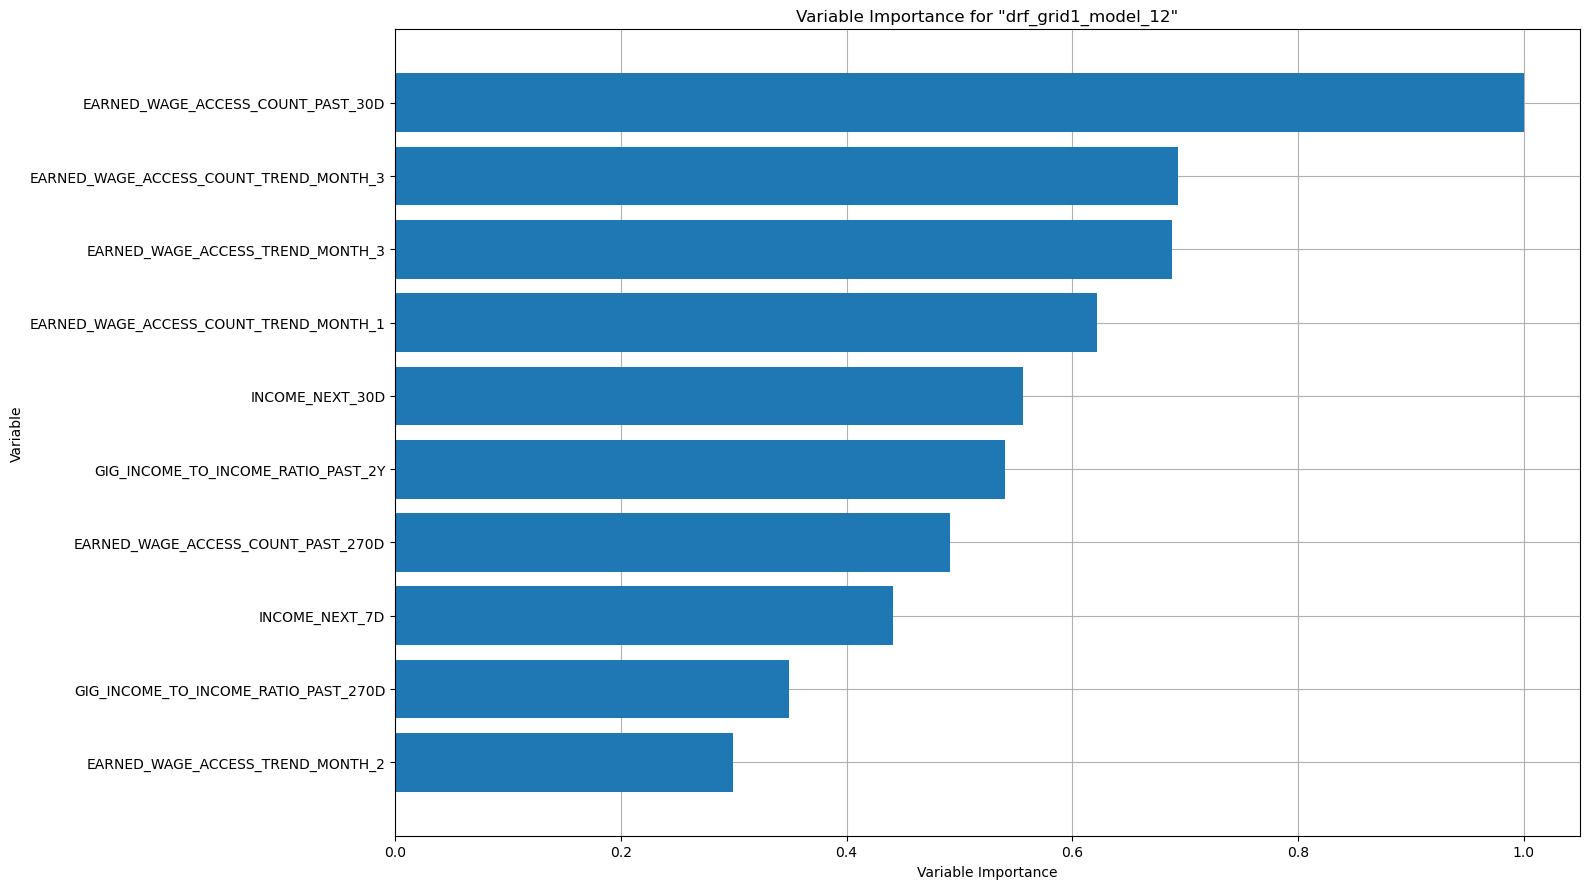

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

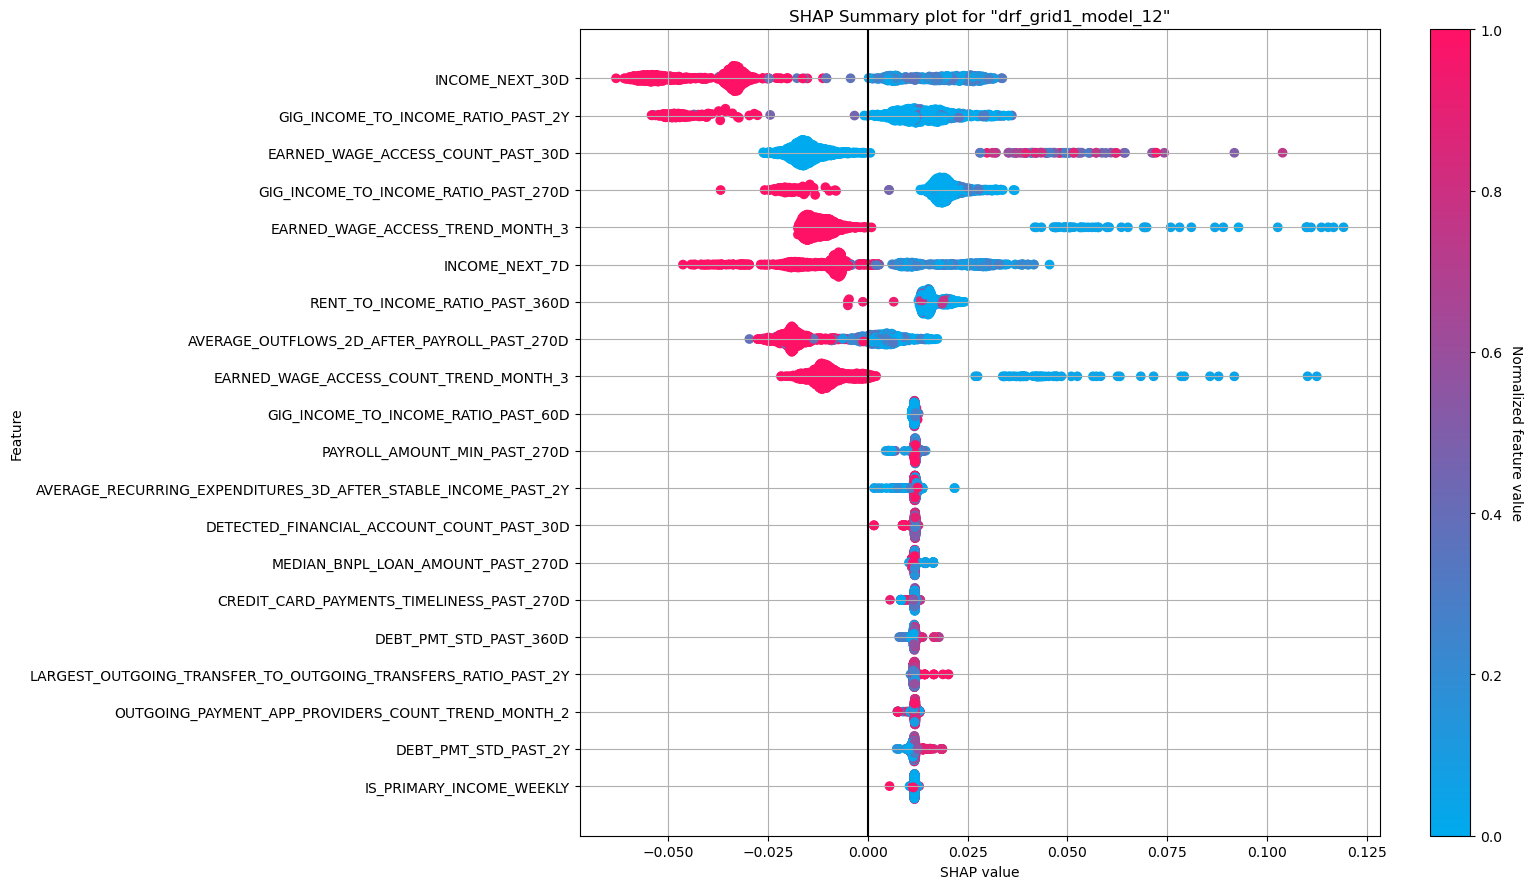

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

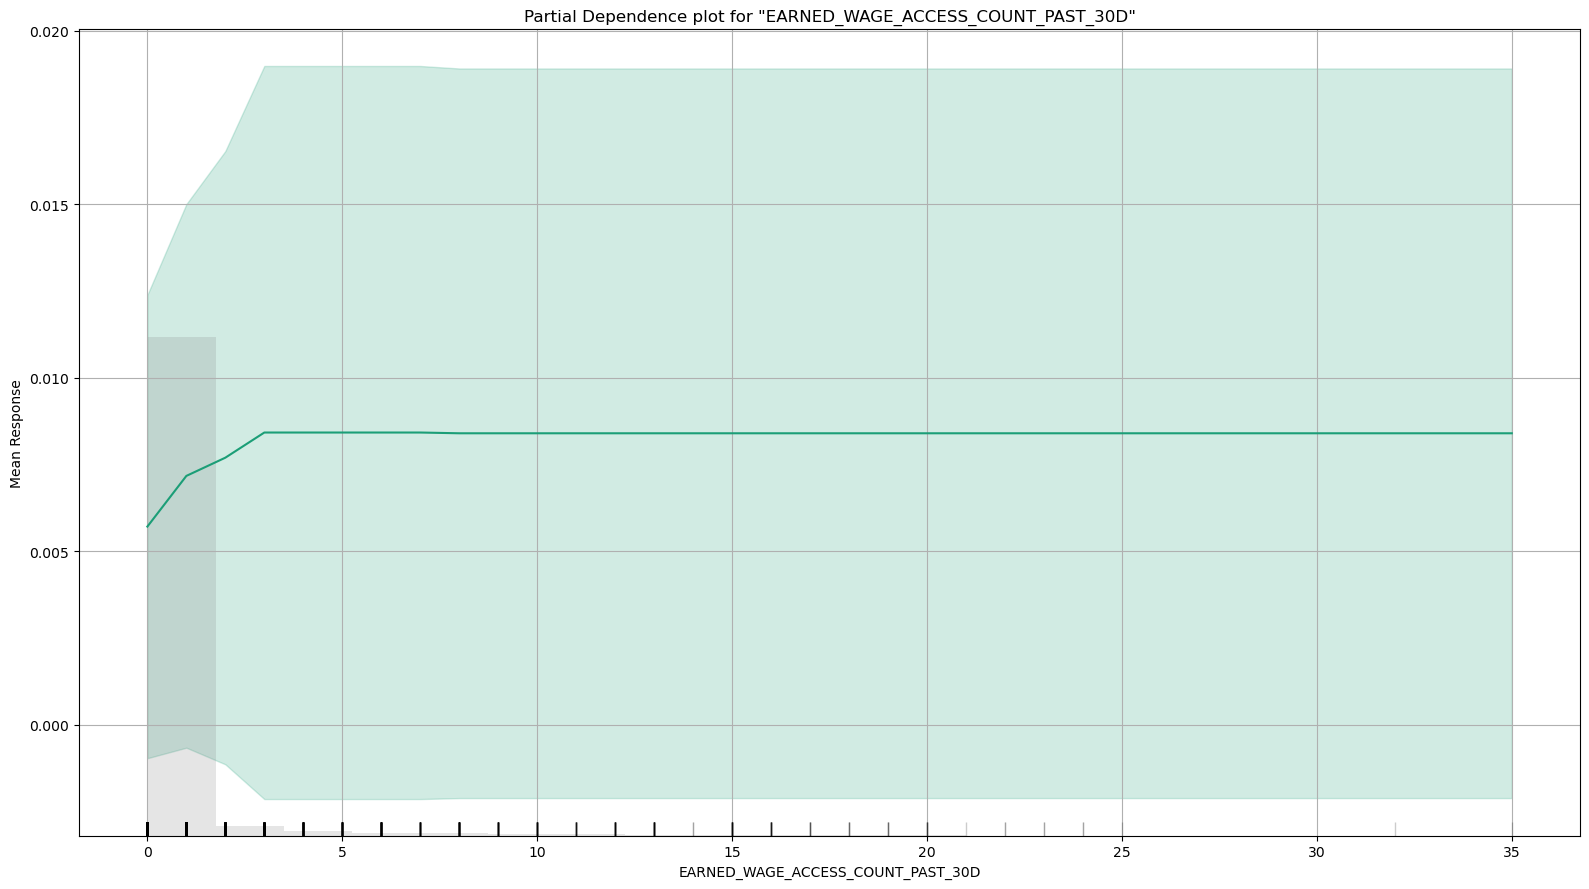

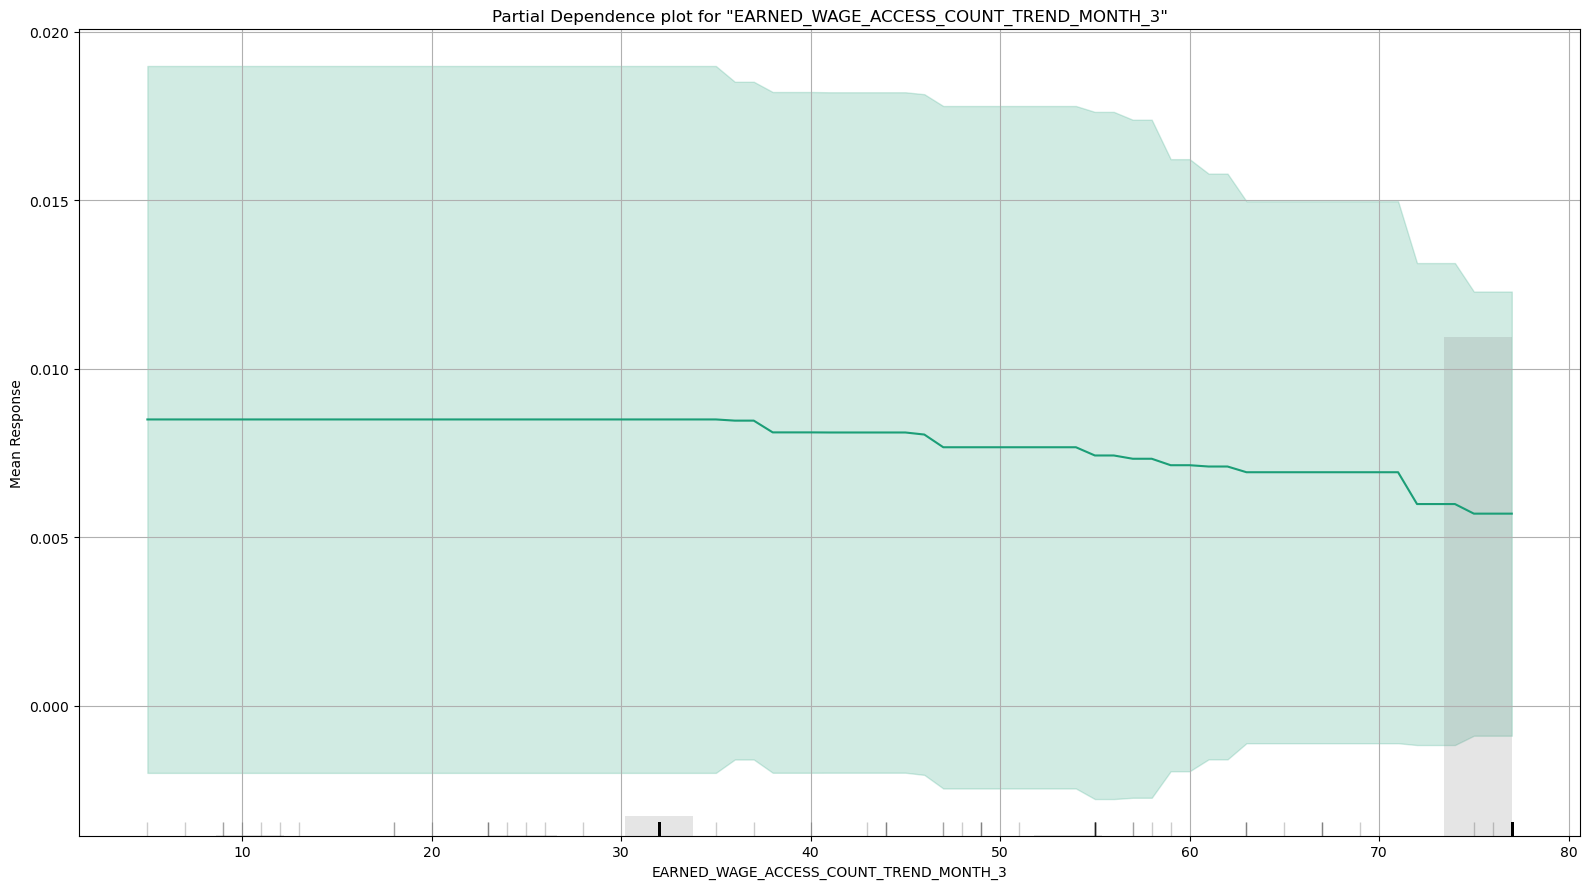

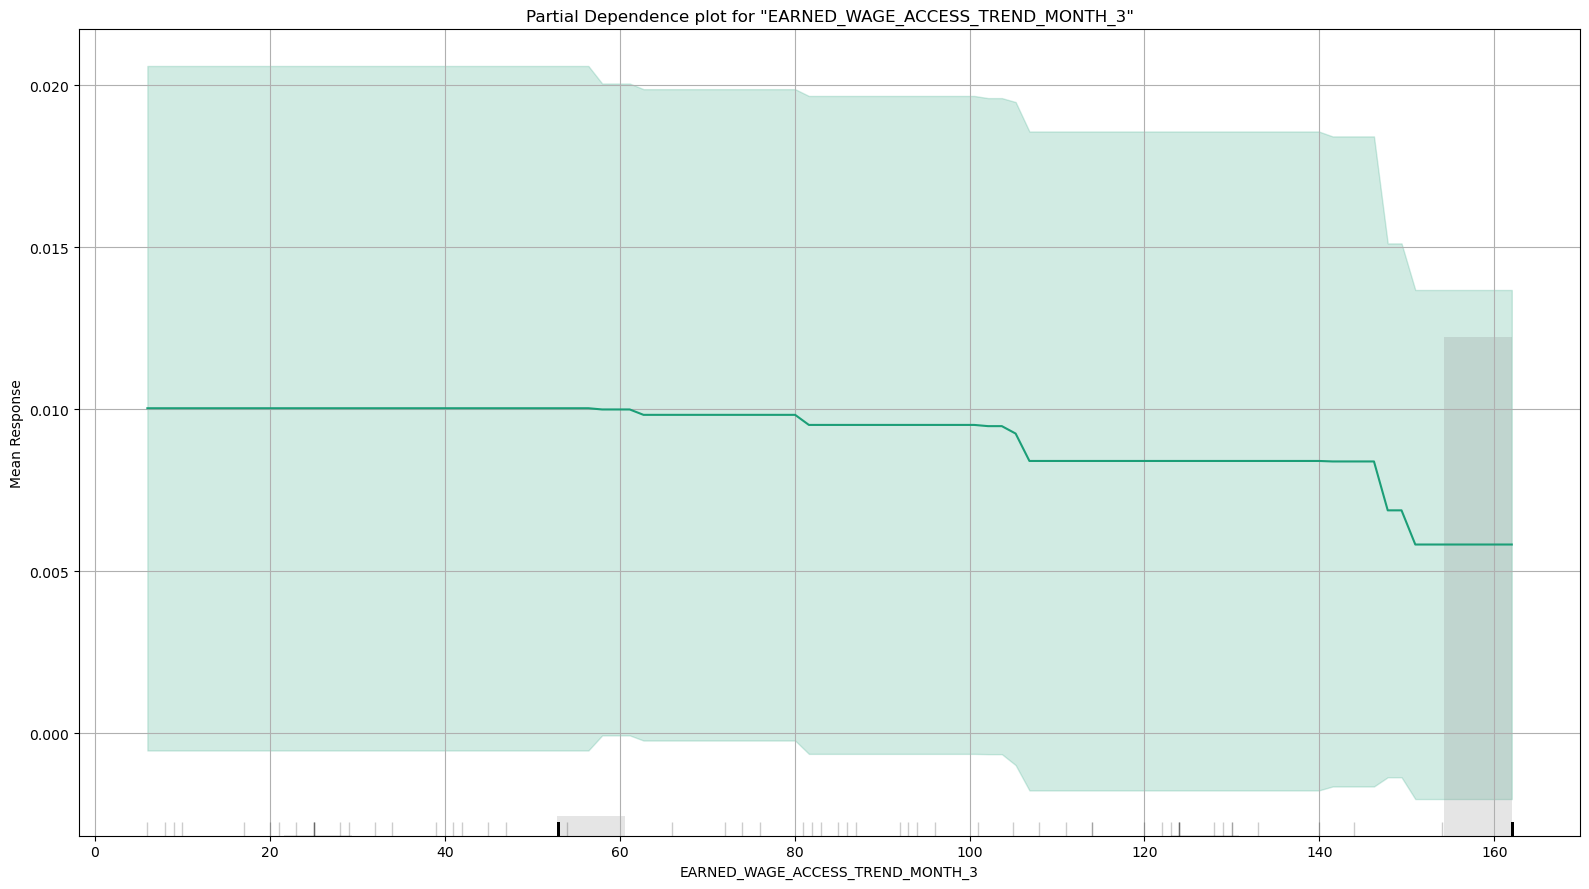

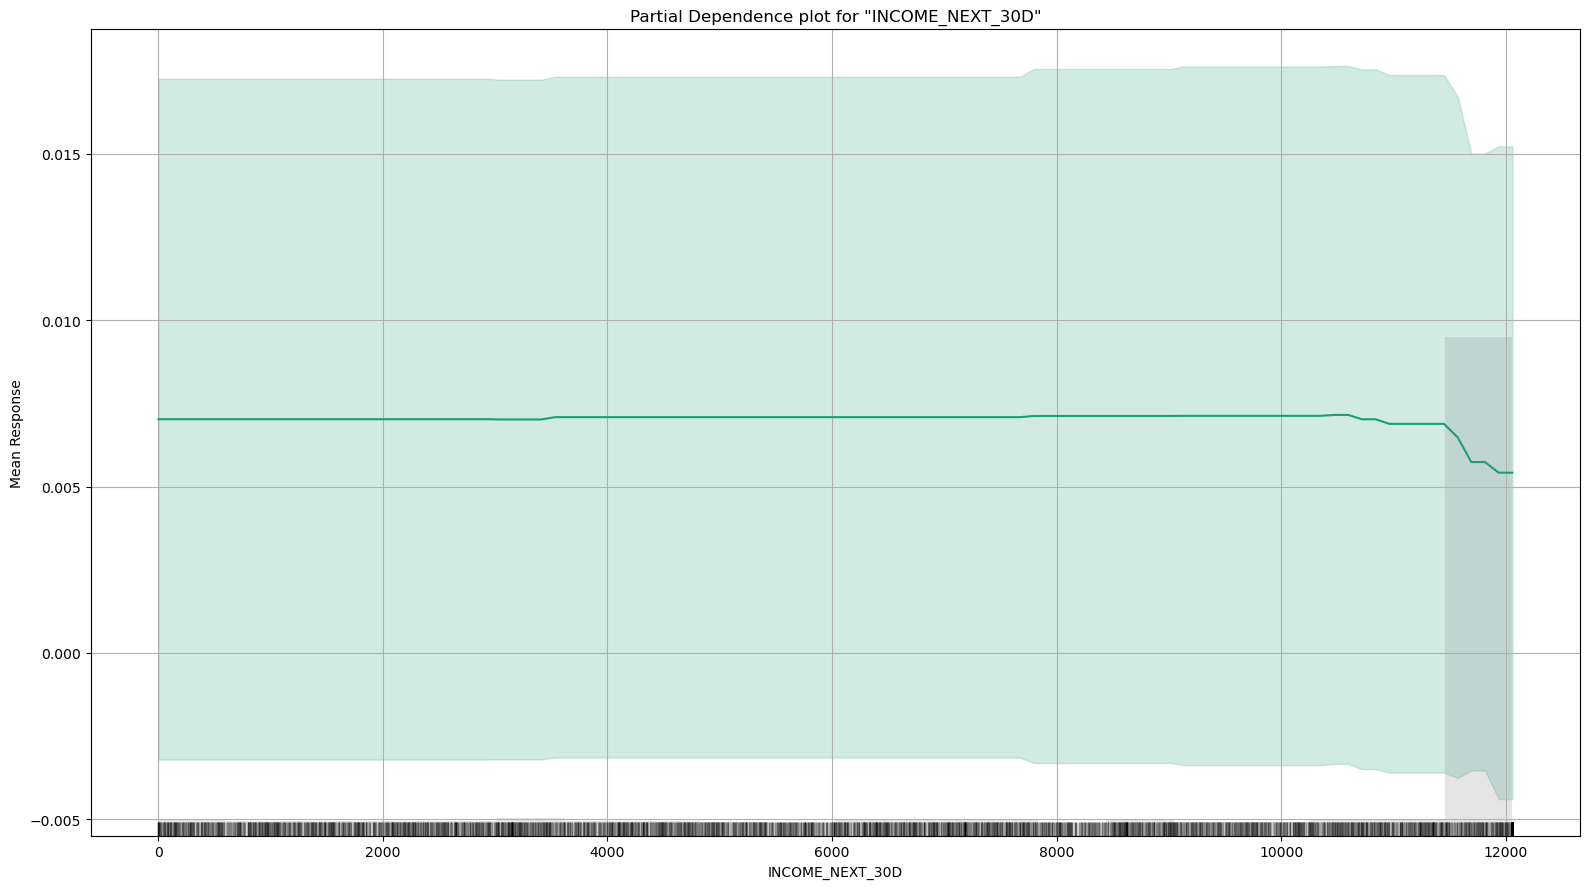

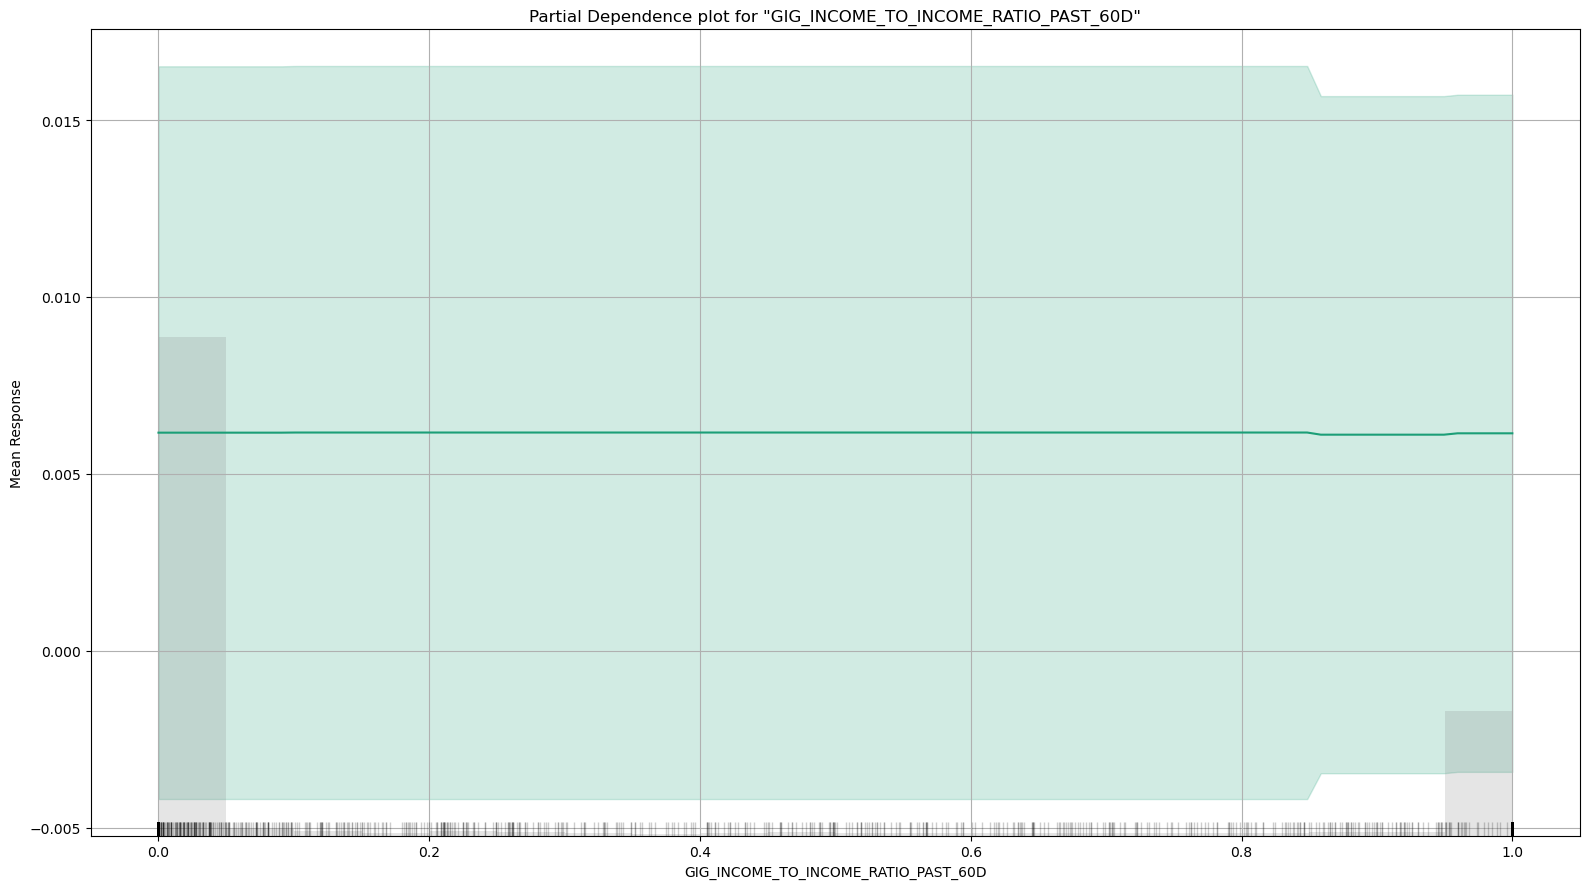

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## drf_grid1_model_12

,0,1,Error,Rate
0,9944.0,35.0,0.0035,(35.0/9979.0)
1,79.0,24.0,0.767,(79.0/103.0)
Total,10023.0,59.0,0.0113,(114.0/10082.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

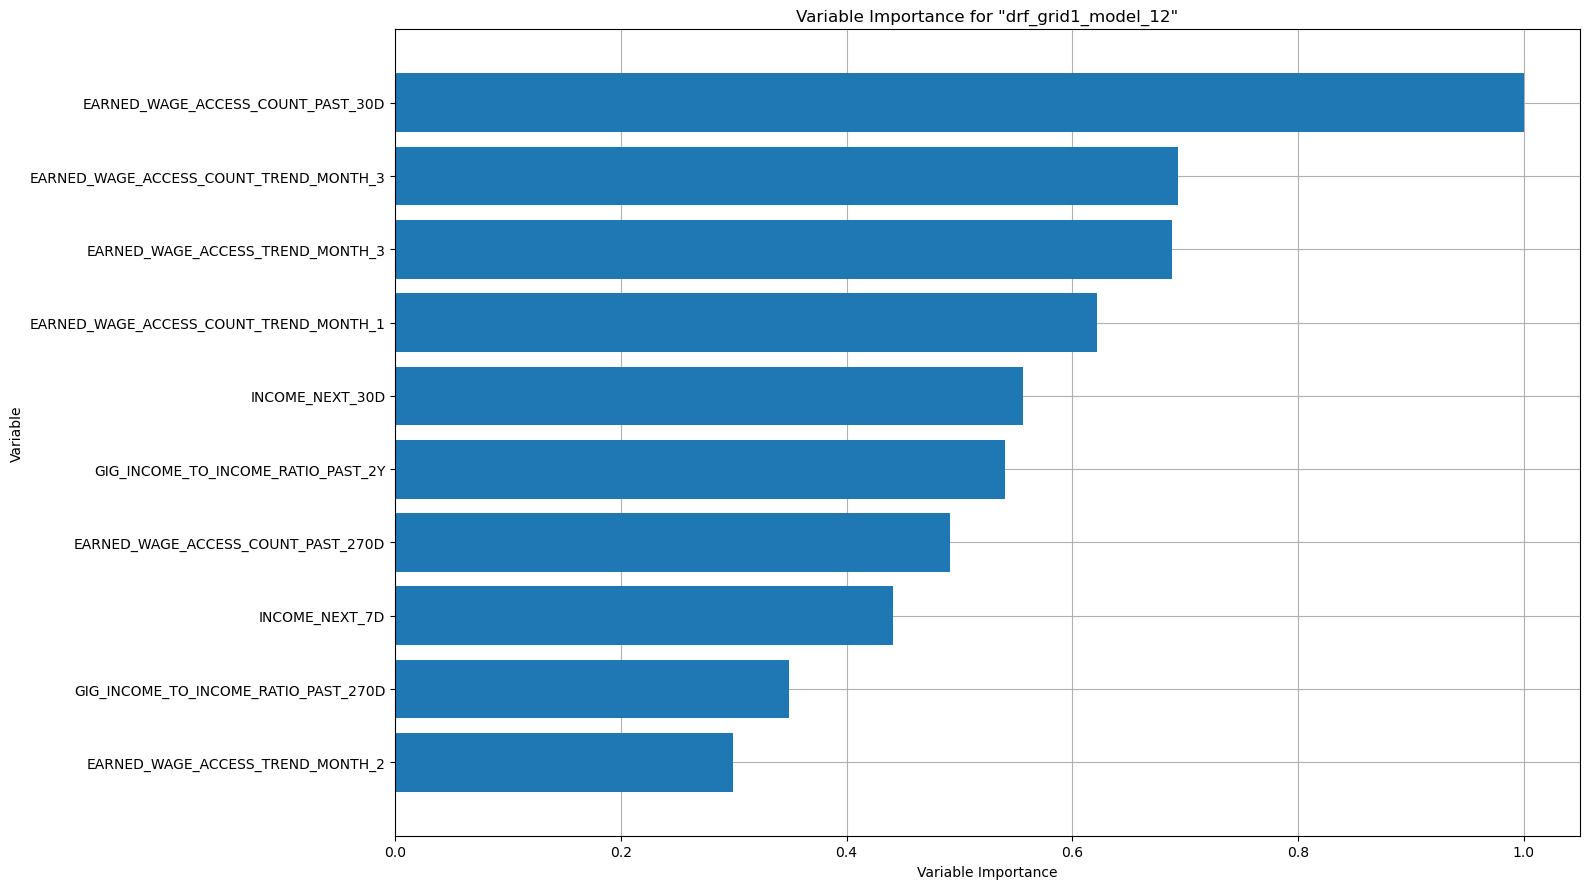

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

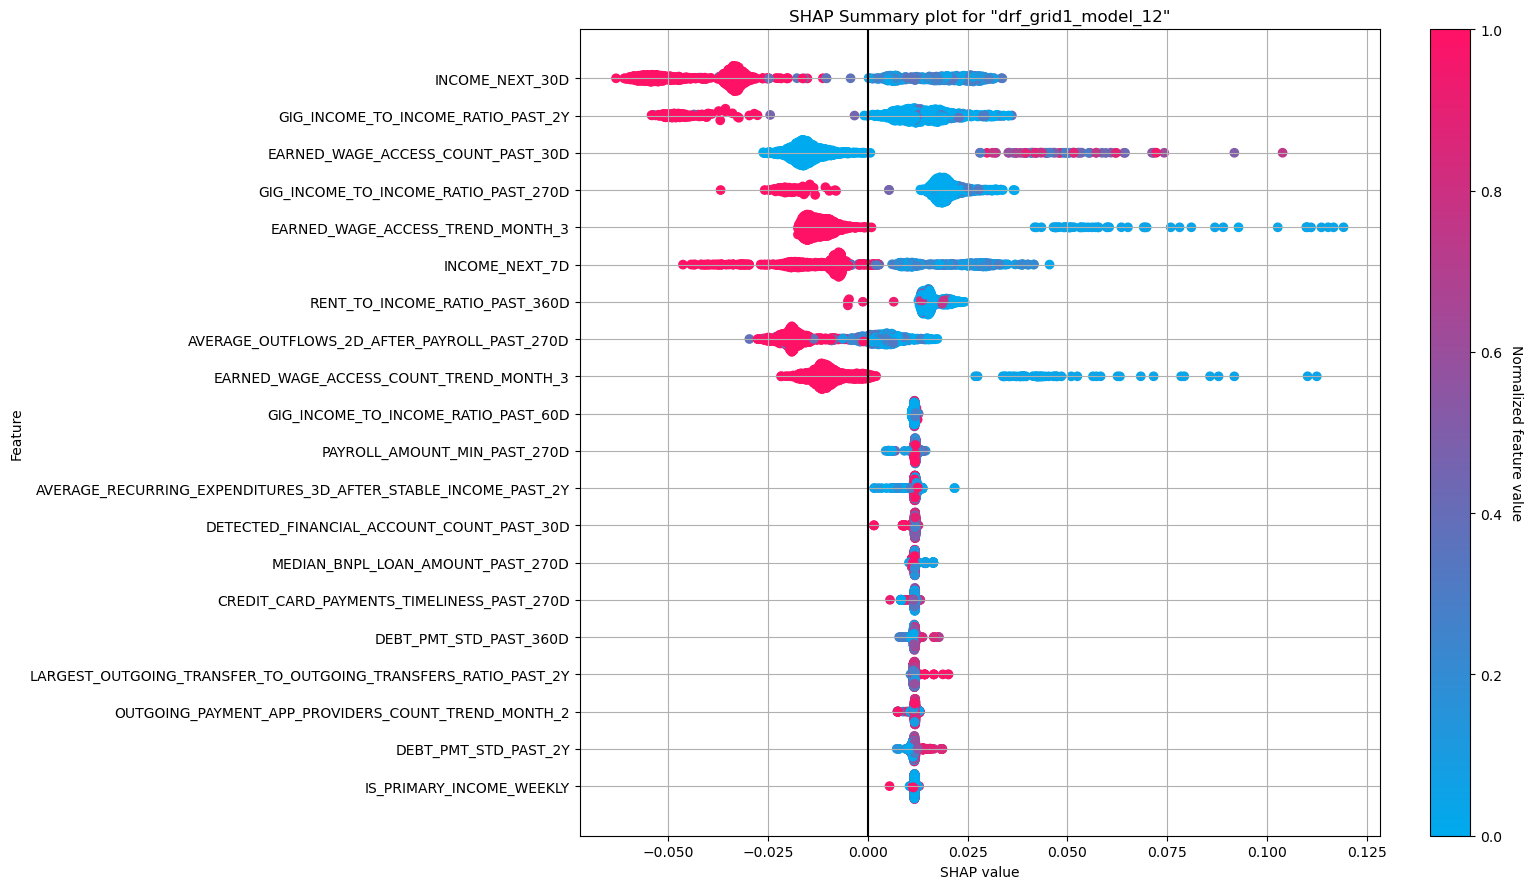

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

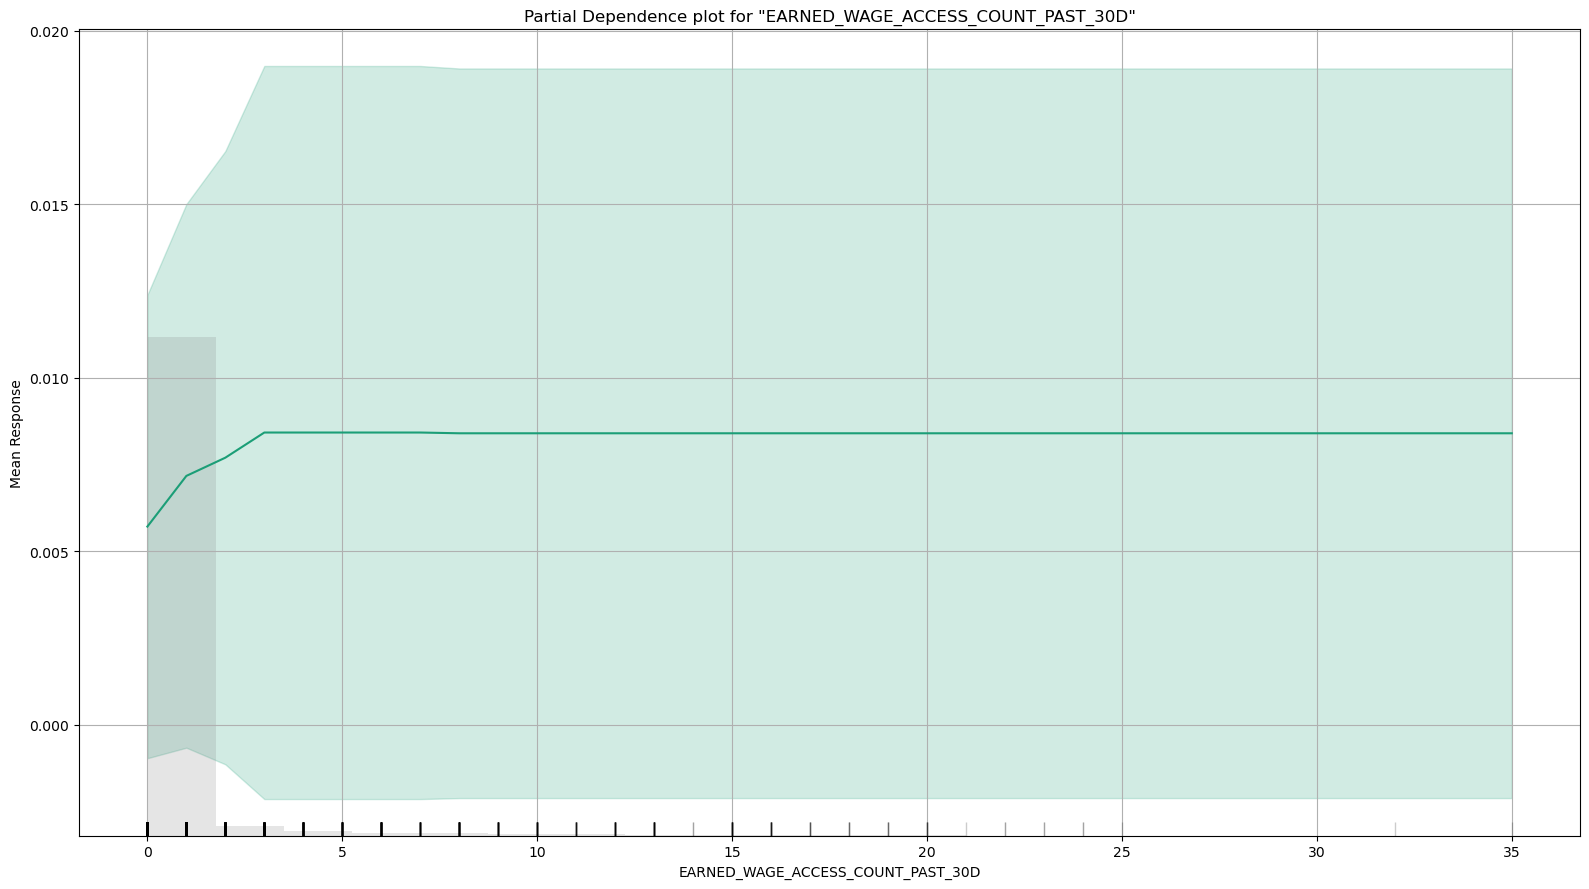

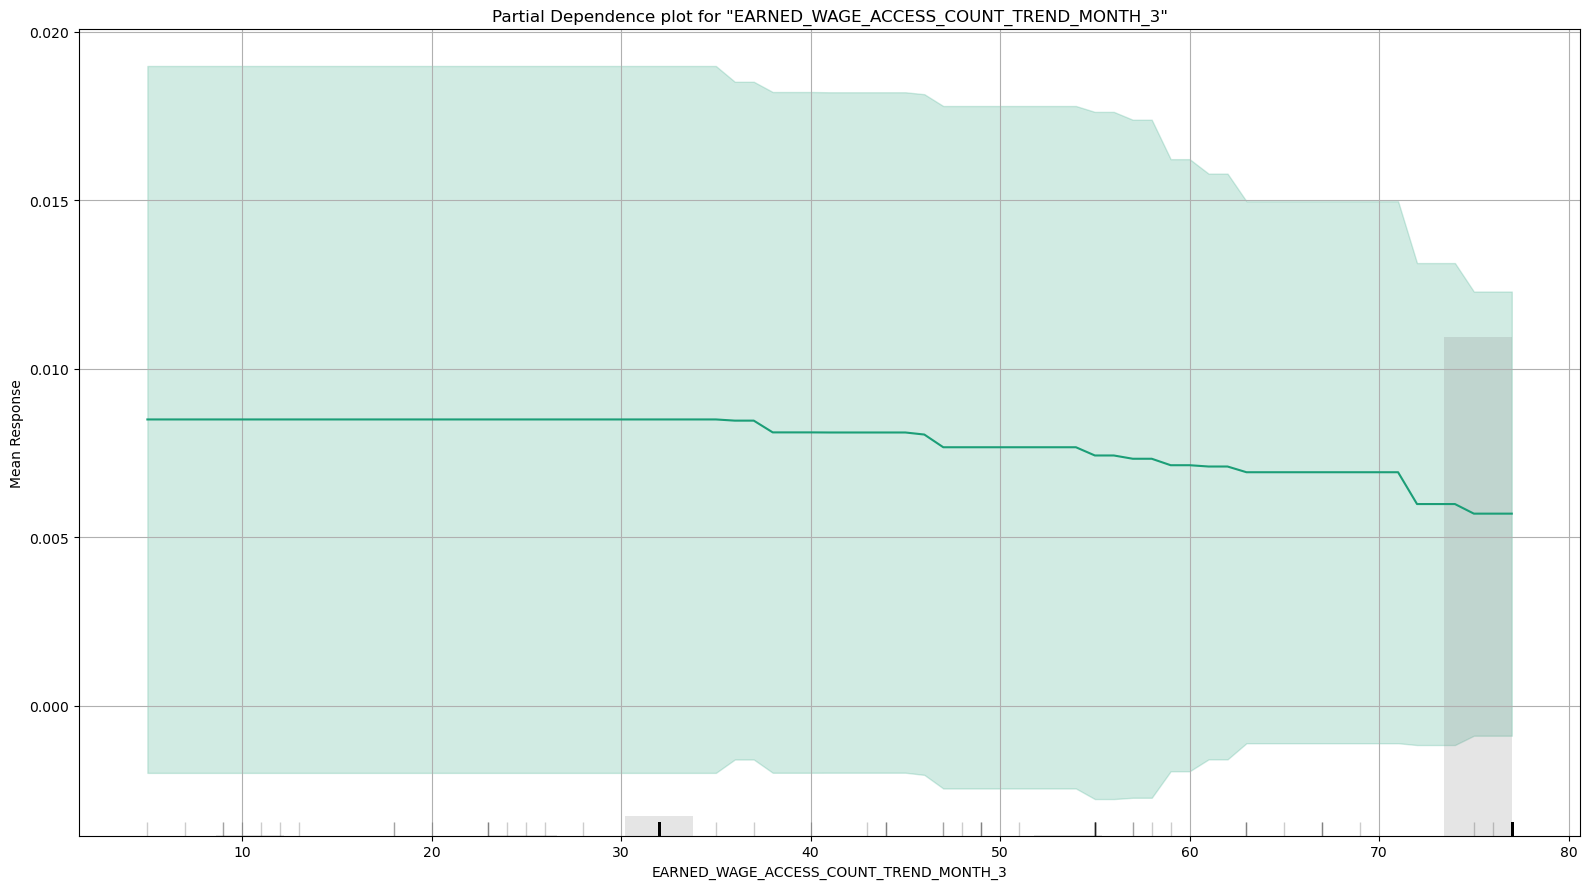

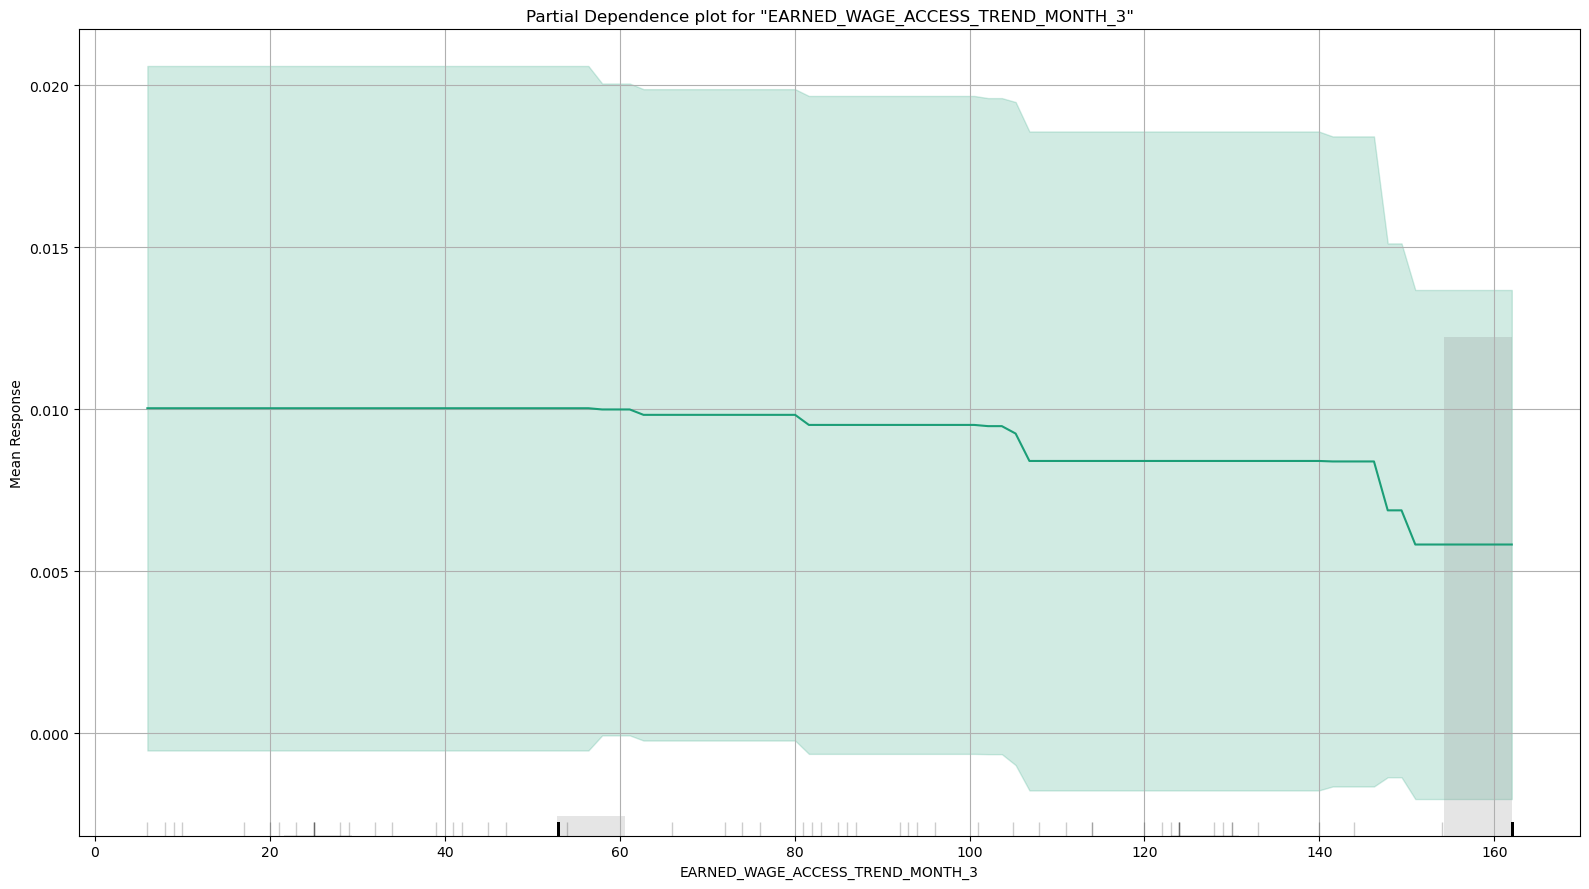

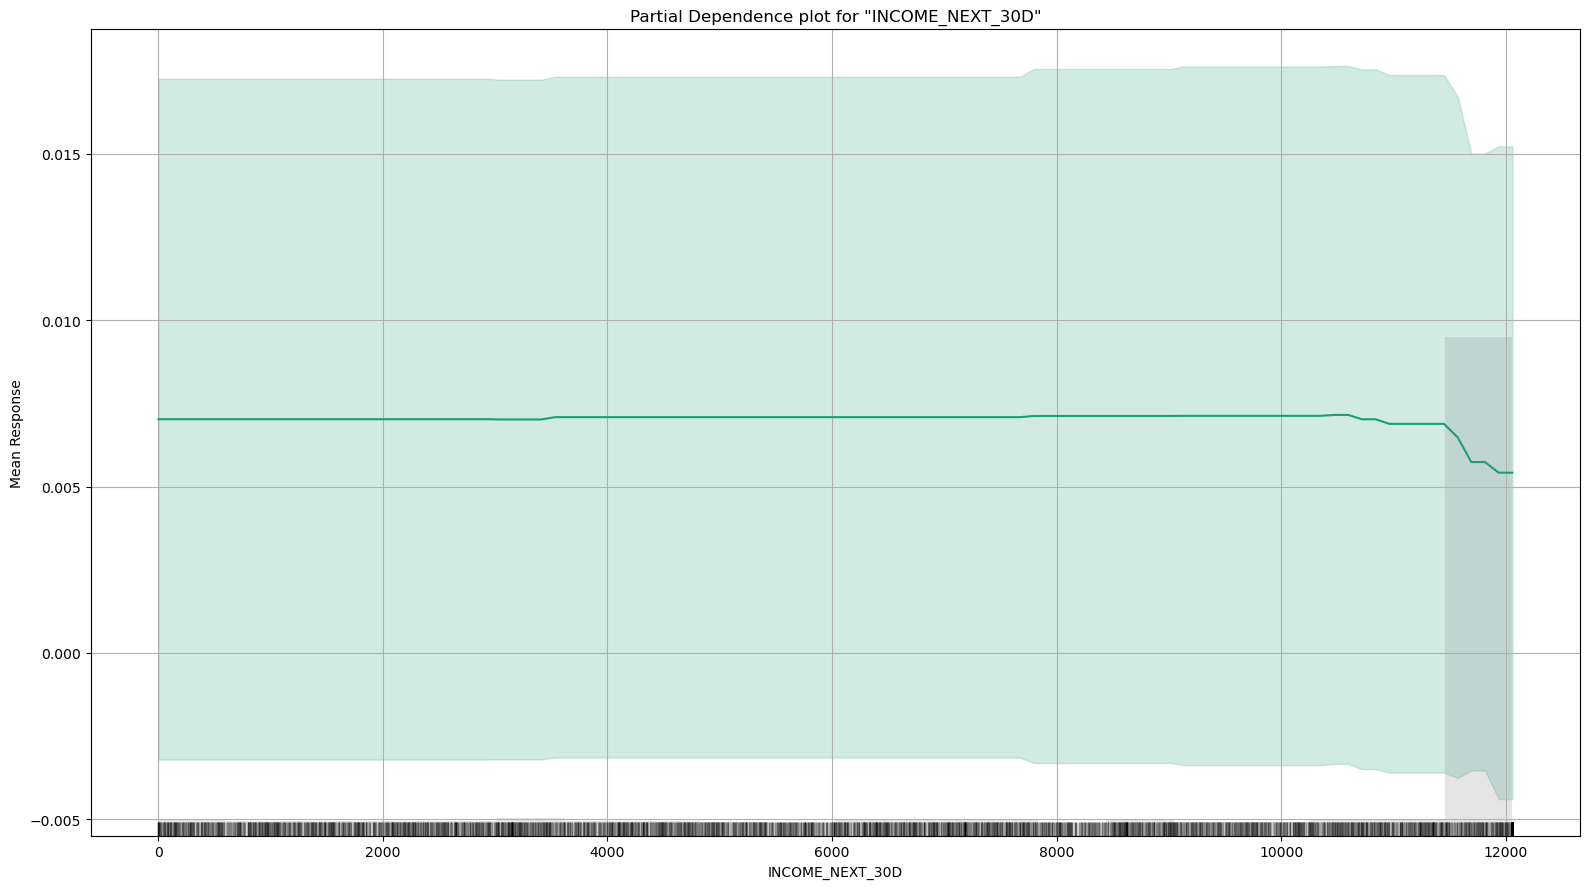

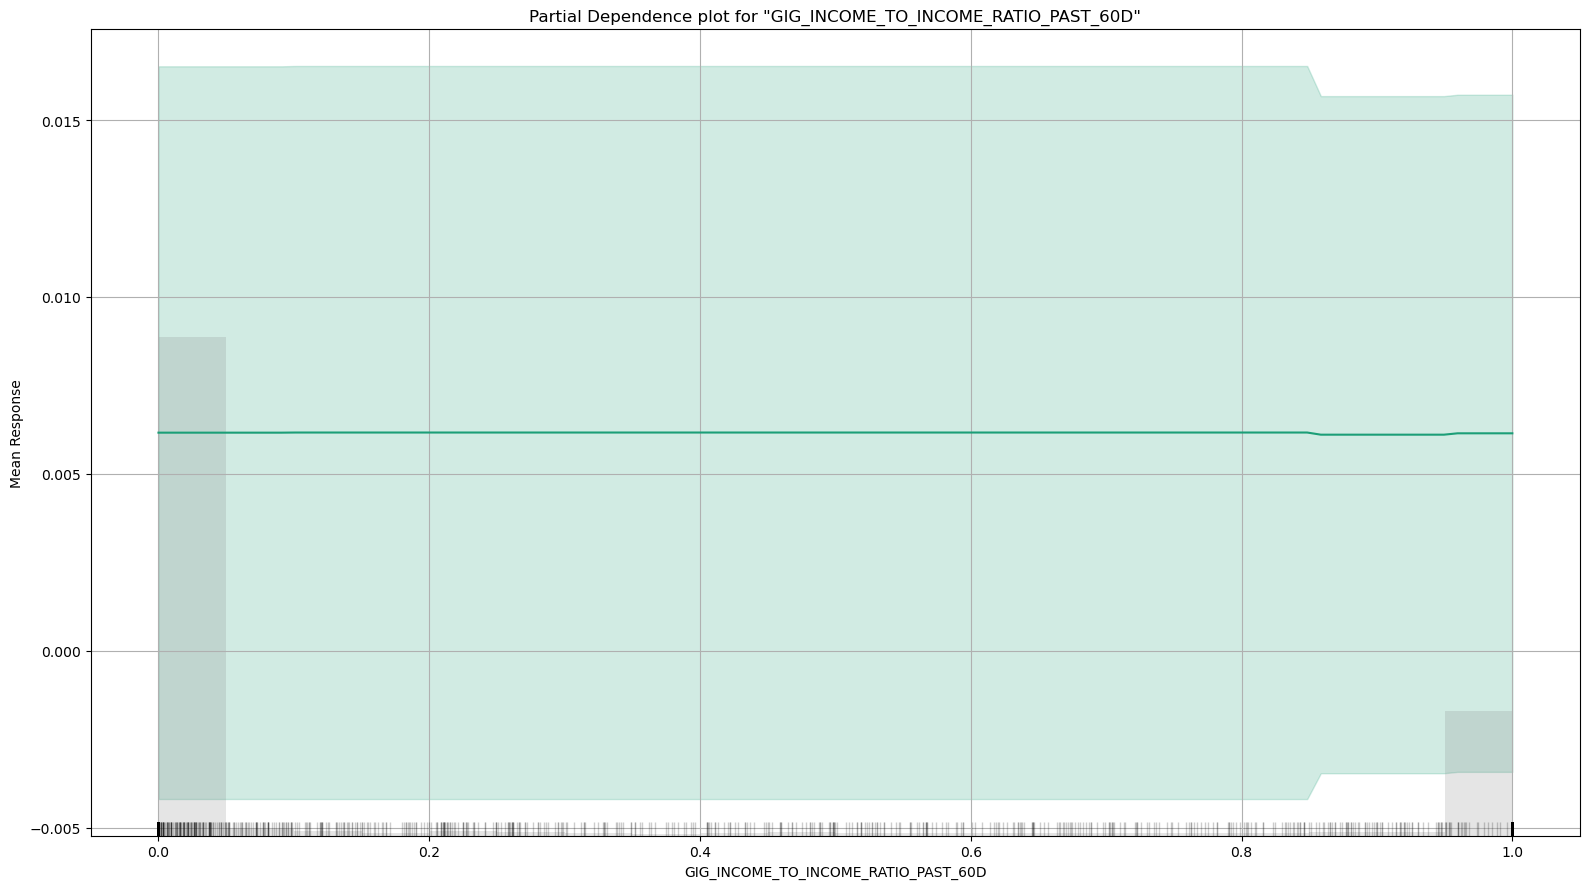

In [154]:
h2o.explain(model, df_test, columns = ['EARNED_WAGE_ACCESS_COUNT_PAST_30D',
                                                             'EARNED_WAGE_ACCESS_COUNT_TREND_MONTH_3',
                                                             'EARNED_WAGE_ACCESS_TREND_MONTH_3',
                                       'INCOME_NEXT_30D',
                                       'GIG_INCOME_TO_INCOME_RATIO_PAST_60D'],
           include_explanations = ['confusion_matrix',
                                   'varimp',
                                   'pdp',
                                  'varimp_heatmap',
                                  'shap_summary',
                                  'ice','model_correlation_heatmap'])